# Dataframes parallel benchmarking using Jupyter
### Kristjan Lõhmus

## 1. Literature review

### 1.2. Running Parallel Computing on Jupyter Notebook: A tutorial on how to utilize Jupyter Notebook for parallel computing, including how to use tools like IPython parallel and Dask. - TechLatest.net

https://medium.com/@techlatest.net/running-parallel-computing-on-jupyter-notebook-a-tutorial-on-how-to-utilize-jupyter-notebook-for-c132e6a53e1d

This article mentions 2 different libraries for parallel computing in jupyter environments:

* IPython parallel
* Dask

No performance metrics are stated in this blog post unfortunately

### 1.4 Dask DataFrame is Fast Now

https://docs.coiled.io/blog/dask-dataframe-is-fast.html

States that the Dask DataFrame scales out pandas DataFrames to operate at the 100GB-100TB scale.

### 1.5 Pandas vs Dask : The Power of Parallel Computing!

https://medium.com/featurepreneur/pandas-vs-dask-the-power-of-parallel-computing-994a202a74bd

Compares pandas to dask. Not too scientific, but gives a sense.

### 1.6 Data Processing at Scale: Comparison of Pandas, Polars, and Dask

https://medium.com/@nandeda.narayan/data-processing-at-scale-comparison-of-pandas-polars-and-dask-333ae65c0a45

No metrics provided, just some examples of common functions in each framework. Does list advantages and disadvantages of each framework.

### 1.7. Pandas 2.0 vs Polars: The Ultimate Battle

https://medium.com/cuenex/pandas-2-0-vs-polars-the-ultimate-battle-a378eb75d6d1

A pretty thorough analysis of pandas and polars. Provides a good list of main functions that are commonly used.

### 1.8 An Empirical Study on the Energy Usage and Performance of Pandas and Polars Data Analysis Python Libraries

https://dl.acm.org/doi/pdf/10.1145/3661167.3661203

TPCH benchmarking both libraries. Polars tends to be more efficient than Pandas while dealing with large dataframes.

### 1.9 Analysis of trade-offs between performance and energy efficiency of scalable Dataframes tools

https://repositorium.uminho.pt/bitstream/1822/92591/1/Andre%20Carvalho%20da%20Cunha%20Martins.pdf

Really thorough 80-page analysis of different packages (polars, pandas etc.). Provides a tool to use for benchmarking.

### 1.10 DuckDB: an Embeddable Analytical Database

https://mytherin.github.io/papers/2019-duckdbdemo.pdf

## 2. Chosen tools

The most common use case for data scientists for reading and manipulating data right now is pandas. Since pandas processes thing linearly, it makes sense to investigate the performance of tools that are similar, but do parallelized computations underneath the hood.
So we will investigate the performance of 3 tools with different datasets and hardware limitations:

1. Pandas
2. Dask
3. Polars
4. DuckDB (?)

In [1]:
def measure_dask_queries(data_path: str, scale: int):
    import time
    import dask_queries
    
    times = []
    for i in range(1,23):
        formatted_number = f"{i:02}"
        start_time = time.time()
        eval(f'dask_queries.query_{formatted_number}("{data_path}", {scale})')
        end_time = time.time()
        times.append(end_time - start_time)
    return times

In [2]:
def measure_polars_queries(data_path: str, scale: int):
    import time
    import polars_queries
    
    times = []
    for i in range(1,23):
        formatted_number = f"{i:02}"
        start_time = time.time()
        eval(f'polars_queries.query_{formatted_number}("{data_path}", {scale})')
        end_time = time.time()
        times.append(end_time - start_time)
    return times

In [3]:
def measure_pandas_queries(data_path: str, scale: int):
    import time
    import pandas_queries
    
    times = []
    for i in range(1,23):
        formatted_number = f"{i:02}"
        start_time = time.time()
        eval(f'pandas_queries.query_{formatted_number}("{data_path}", {scale})')
        end_time = time.time()
        times.append(end_time - start_time)
    return times

In [4]:
def measure_duckdb_queries(scale: int):
    import duckdb
    import time
    conn = duckdb.connect()
    
    conn.sql(f"CREATE TABLE customer AS FROM read_csv('./data/scale_factor_{scale}/customer.csv')")
    conn.sql(f"CREATE TABLE nation AS FROM read_csv('./data/scale_factor_{scale}/nation.csv')")
    conn.sql(f"CREATE TABLE lineitem AS FROM read_csv('./data/scale_factor_{scale}/lineitem.csv')")
    conn.sql(f"CREATE TABLE orders AS FROM read_csv('./data/scale_factor_{scale}/orders.csv')")
    conn.sql(f"CREATE TABLE supplier AS FROM read_csv('./data/scale_factor_{scale}/supplier.csv')")
    conn.sql(f"CREATE TABLE region AS FROM read_csv('./data/scale_factor_{scale}/region.csv')")
    conn.sql(f"CREATE TABLE part AS FROM read_csv('./data/scale_factor_{scale}/part.csv')")
    conn.sql(f"CREATE TABLE partsupp AS FROM read_csv('./data/scale_factor_{scale}/partsupp.csv')")
    times = []
    for i in range(1,23):
        start_time = time.time()
        query = None
        with open(f'./duckdb_queries/{i}.sql') as f:
            query = f.read()
        result = conn.sql(query).df()
        end_time = time.time()
        times.append(end_time - start_time)
    return times

In [6]:
results = []
for factor in [1, 5, 10]:
    print(f'Measuring dask runtimes for scale {factor}')
    dask_results = measure_dask_queries(data_path=f'./data/scale_factor_{factor}', scale=factor)
    print(f'Measuring polars runtimes for scale {factor}')
    polars_results = measure_polars_queries(data_path=f'./data/scale_factor_{factor}', scale=factor)
    print(f'Measuring pandas runtimes for scale {factor}')
    pandas_results = measure_pandas_queries(data_path=f'./data/scale_factor_{factor}', scale=factor)
    print(f'Measuring duckdb runtimes for scale {factor}')
    duckdb_results = measure_duckdb_queries(factor)
    for i in range(0,22):
        results.append({'library': 'dask', 'scale': factor, f'query_{i + 1}': dask_results[i]})
        results.append({'library': 'polars', 'scale': factor, f'query_{i + 1}': polars_results[i]})
        results.append({'library': 'pandas', 'scale': factor, f'query_{i + 1}': pandas_results[i]})
        results.append({'library': 'duckdb', 'scale': factor, f'query_{i + 1}': duckdb_results[i]})

Measuring dask runtimes for scale 1
Measuring polars runtimes for scale 1
Measuring pandas runtimes for scale 1


C:\Users\KristjanLõhmus\Documents\Projects\hajussüsteemid\src\pandas_queries.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineitem_filtered["l_year"] = lineitem_filtered["l_shipdate"].dt.year
C:\Users\KristjanLõhmus\Documents\Projects\hajussüsteemid\src\pandas_queries.py:312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineitem_filtered["volume"] = lineitem_filtered["l_extendedprice"] * (
C:\Users\KristjanLõhmus\Documents\Projects\hajussüsteemid\src\pandas_queries.py:424: SettingWithCopyWarning: 

Measuring duckdb runtimes for scale 1
Measuring dask runtimes for scale 5
Measuring polars runtimes for scale 5
Measuring pandas runtimes for scale 5


C:\Users\KristjanLõhmus\Documents\Projects\hajussüsteemid\src\pandas_queries.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineitem_filtered["l_year"] = lineitem_filtered["l_shipdate"].dt.year
C:\Users\KristjanLõhmus\Documents\Projects\hajussüsteemid\src\pandas_queries.py:312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineitem_filtered["volume"] = lineitem_filtered["l_extendedprice"] * (
C:\Users\KristjanLõhmus\Documents\Projects\hajussüsteemid\src\pandas_queries.py:424: SettingWithCopyWarning: 

Measuring duckdb runtimes for scale 5


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Measuring dask runtimes for scale 10
Measuring polars runtimes for scale 10
Measuring pandas runtimes for scale 10


C:\Users\KristjanLõhmus\Documents\Projects\hajussüsteemid\src\pandas_queries.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineitem_filtered["l_year"] = lineitem_filtered["l_shipdate"].dt.year
C:\Users\KristjanLõhmus\Documents\Projects\hajussüsteemid\src\pandas_queries.py:312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineitem_filtered["volume"] = lineitem_filtered["l_extendedprice"] * (
C:\Users\KristjanLõhmus\Documents\Projects\hajussüsteemid\src\pandas_queries.py:424: SettingWithCopyWarning: 

Measuring duckdb runtimes for scale 10


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [14]:
import pandas as pd
df = pd.DataFrame(results)
df = df.groupby(['library', 'scale']).max().reset_index()
df

,library,scale,query_1,query_2,query_3,query_4,query_5,query_6,query_7,query_8,...,query_13,query_14,query_15,query_16,query_17,query_18,query_19,query_20,query_21,query_22
0,dask,1,0.034288,0.066900,0.050400,0.030410,0.084703,0.013157,0.137387,0.114216,...,0.025341,0.030732,0.026553,0.040670,0.043244,0.058425,0.037147,0.061564,0.052397,0.032031
1,dask,5,0.044552,0.187590,0.054078,0.027820,0.079076,0.014999,0.126850,0.118643,...,0.027091,0.032003,0.028650,0.037081,0.037997,0.052513,0.035781,0.059921,0.058252,0.032329
2,dask,10,0.221208,0.219501,0.085751,0.039748,0.095878,0.022088,0.159824,0.144335,...,0.034999,0.043554,0.037262,0.053290,0.058210,0.068895,0.044000,0.079509,0.066808,0.040999
3,duckdb,1,0.044949,0.048013,0.047345,0.050976,0.063803,0.006489,0.047920,0.048060,...,0.067405,0.019802,0.036404,0.051007,0.058677,0.091054,0.057691,0.041512,0.136760,0.030494
4,duckdb,5,0.315937,0.545591,0.262013,0.369135,0.345844,0.031511,0.403491,0.335500,...,0.664696,0.232125,0.178079,0.455897,0.359312,1.251886,0.418455,0.299249,1.148395,0.199629
5,duckdb,10,0.673697,1.428819,0.686594,0.851506,0.833413,0.059550,1.353770,0.929297,...,2.370712,0.781172,0.517981,2.039258,0.958619,4.565969,1.085648,0.788578,3.099705,0.633831
6,pandas,1,14.442873,1.573162,16.387560,16.173246,16.644339,13.613843,16.840018,16.774032,...,3.227105,13.979963,13.643740,1.596735,14.355726,16.570478,14.602863,15.907717,17.807833,2.696011
7,pandas,5,81.260854,8.066207,99.105616,93.773198,97.641043,81.275037,99.246283,100.685844,...,17.816908,86.899685,85.719816,7.939521,93.674596,102.495577,92.300865,96.032925,115.164488,14.265036
8,pandas,10,248.687088,17.610424,262.938035,280.136163,275.373519,235.826325,288.339087,283.802637,...,41.886713,265.518068,271.945392,18.191106,281.514663,302.012948,303.295824,291.403991,339.592806,35.902997
9,polars,1,0.709137,0.293186,0.489748,0.472204,0.486151,0.399033,0.559224,0.478138,...,0.201157,0.449589,0.432278,0.089645,0.666231,0.722002,0.510283,0.524311,2.514762,0.132097


In [17]:
df.to_csv('./data/results.csv', index=False)

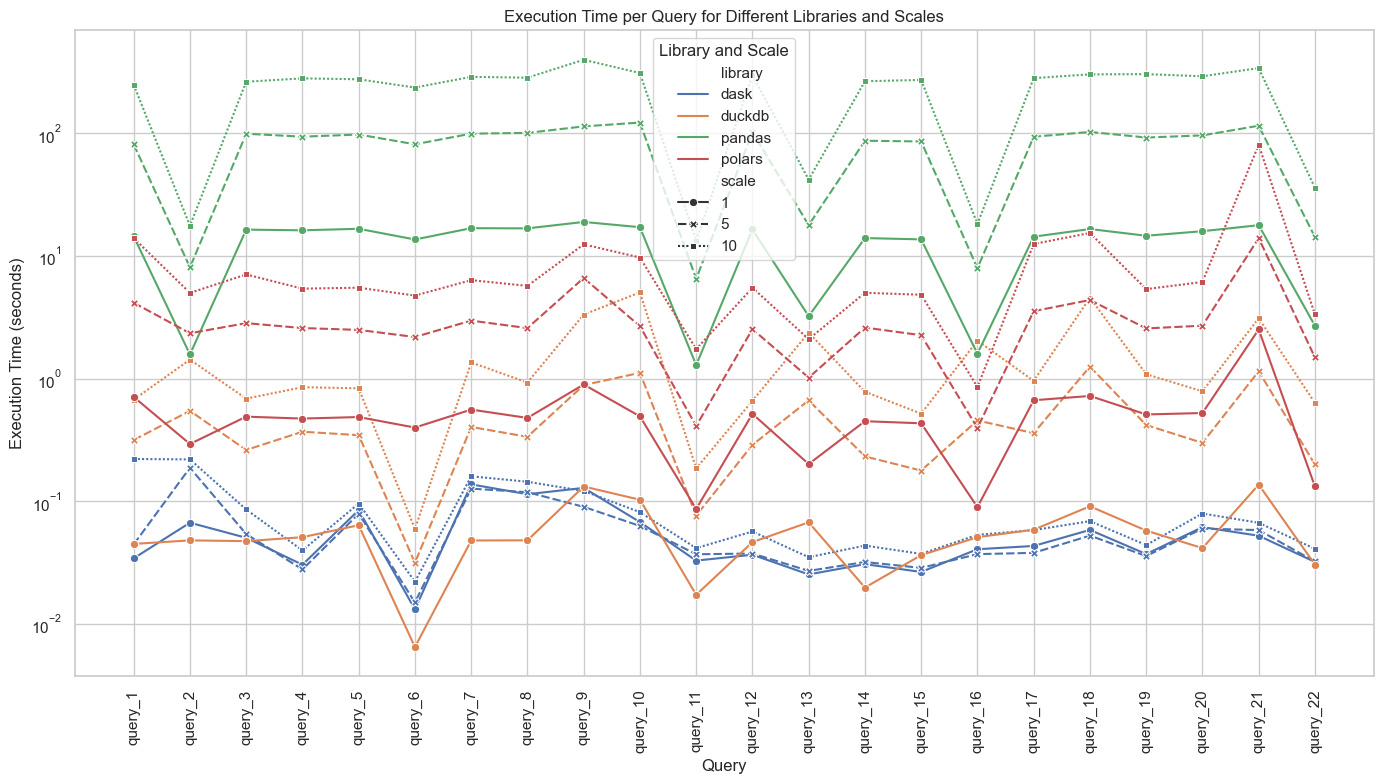

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

df_long = df.melt(id_vars=["library", "scale"], var_name="query", value_name="time")

# 1. Summarize average execution time per library and scale
summary_avg = df_long.groupby(["library", "scale"])["time"].mean().unstack()

# 2. Identify the fastest library per scale for each query
fastest_by_scale = df_long.loc[df_long.groupby(["query", "scale"])["time"].idxmin()]

# 3. Calculate the standard deviation and mean for each query across libraries and scales
query_stats = df_long.groupby(["query", "library"])["time"].agg(["mean", "std"]).unstack()

sns.set(style="whitegrid")

# Plot average time per query by scale for each library
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_long, x="query", y="time", hue="library", style="scale", markers=True)
plt.xticks(rotation=90)
plt.yscale("log")  # Set log scale if times vary widely
plt.title("Execution Time per Query for Different Libraries and Scales")
plt.xlabel("Query")
plt.ylabel("Execution Time (seconds)")
plt.legend(title="Library and Scale")
plt.tight_layout()
plt.show()

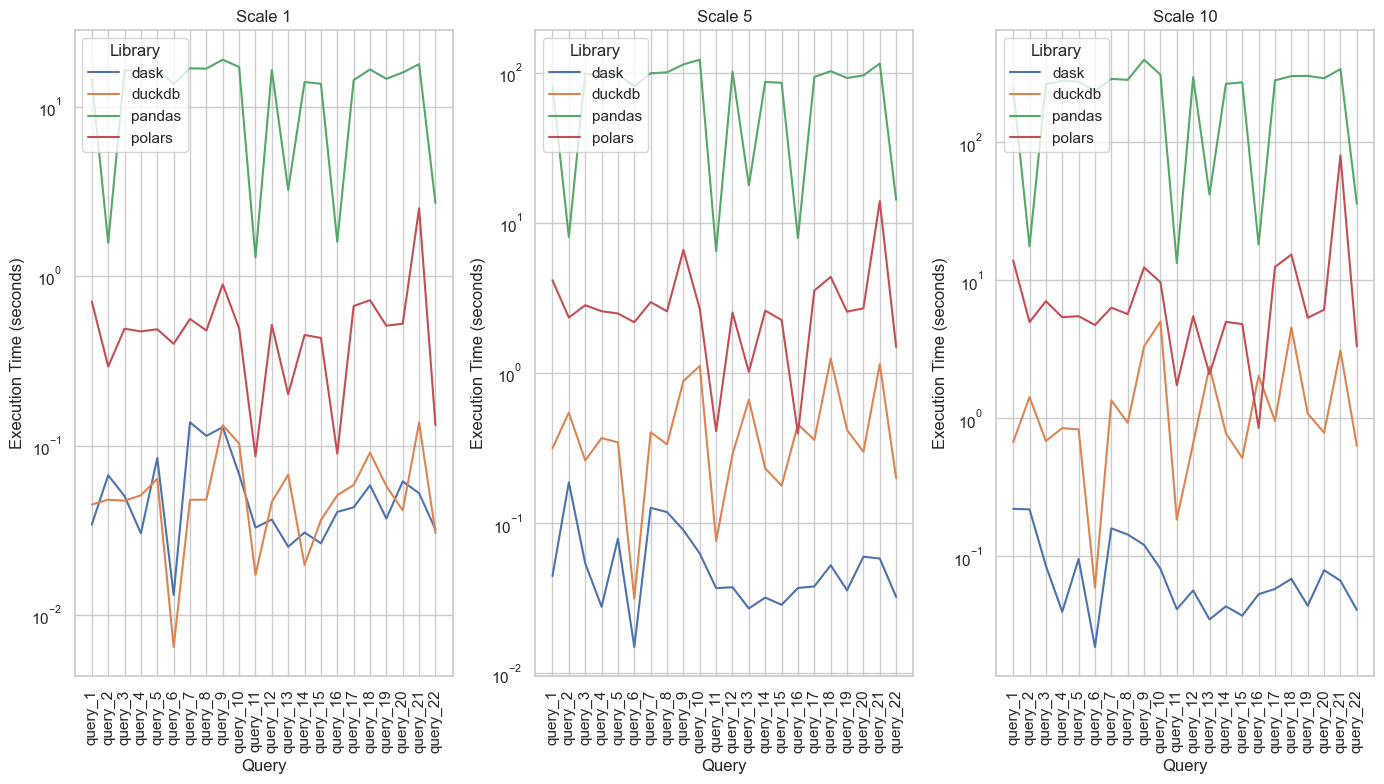

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Plot execution time per query for each scale, with separate plots for each
scales = df["scale"].unique()

plt.figure(figsize=(14, 8))
for i, scale in enumerate(scales, start=1):
    plt.subplot(1, len(scales), i)  # Create a subplot for each scale
    subset = df_long[df_long["scale"] == scale]  # Filter data by scale
    sns.lineplot(data=subset, x="query", y="time", hue="library", markers=True)
    plt.yscale("log")  # Set y-axis to log scale if needed
    plt.title(f"Scale {scale}")
    plt.xlabel("Query")
    plt.ylabel("Execution Time (seconds)")
    plt.xticks(rotation=90)
    plt.legend(title="Library", loc="upper left")

plt.tight_layout()
plt.show()

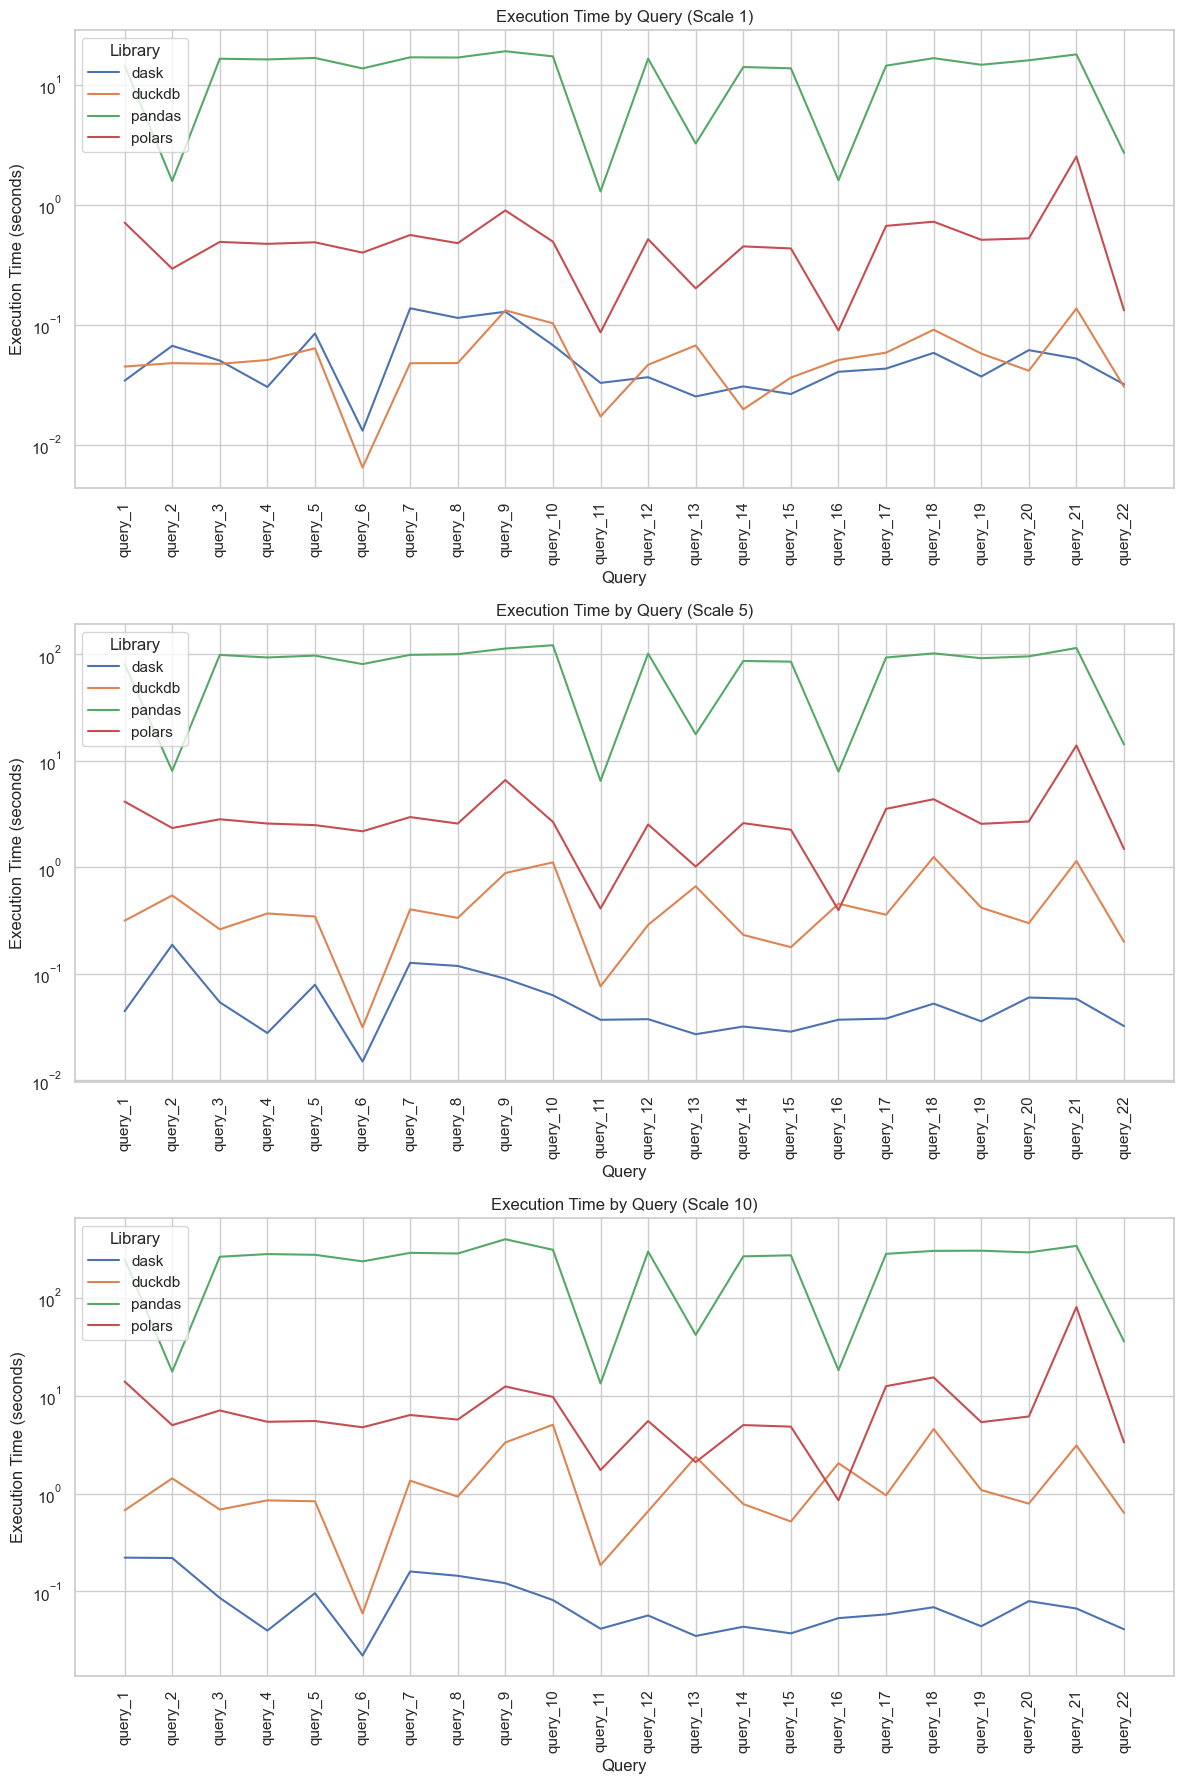

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Create a bar graph for each scale with vertical layout
scales = df["scale"].unique()

# Set the figure size to accommodate vertical layout
plt.figure(figsize=(12, 18))

for i, scale in enumerate(scales, start=1):
    plt.subplot(len(scales), 1, i)  # Create a subplot for each scale in a single column
    subset = df_long[df_long["scale"] == scale]  # Filter data by scale
    
    # Create a barplot for the current scale
    sns.lineplot(data=subset, x="query", y="time", hue="library")
    plt.yscale("log")  # Use log scale if times vary widely
    plt.title(f"Execution Time by Query (Scale {scale})")
    plt.xlabel("Query")
    plt.ylabel("Execution Time (seconds)")
    plt.xticks(rotation=90)
    plt.legend(title="Library", loc="upper left")

# Adjust layout
plt.tight_layout()
plt.show()


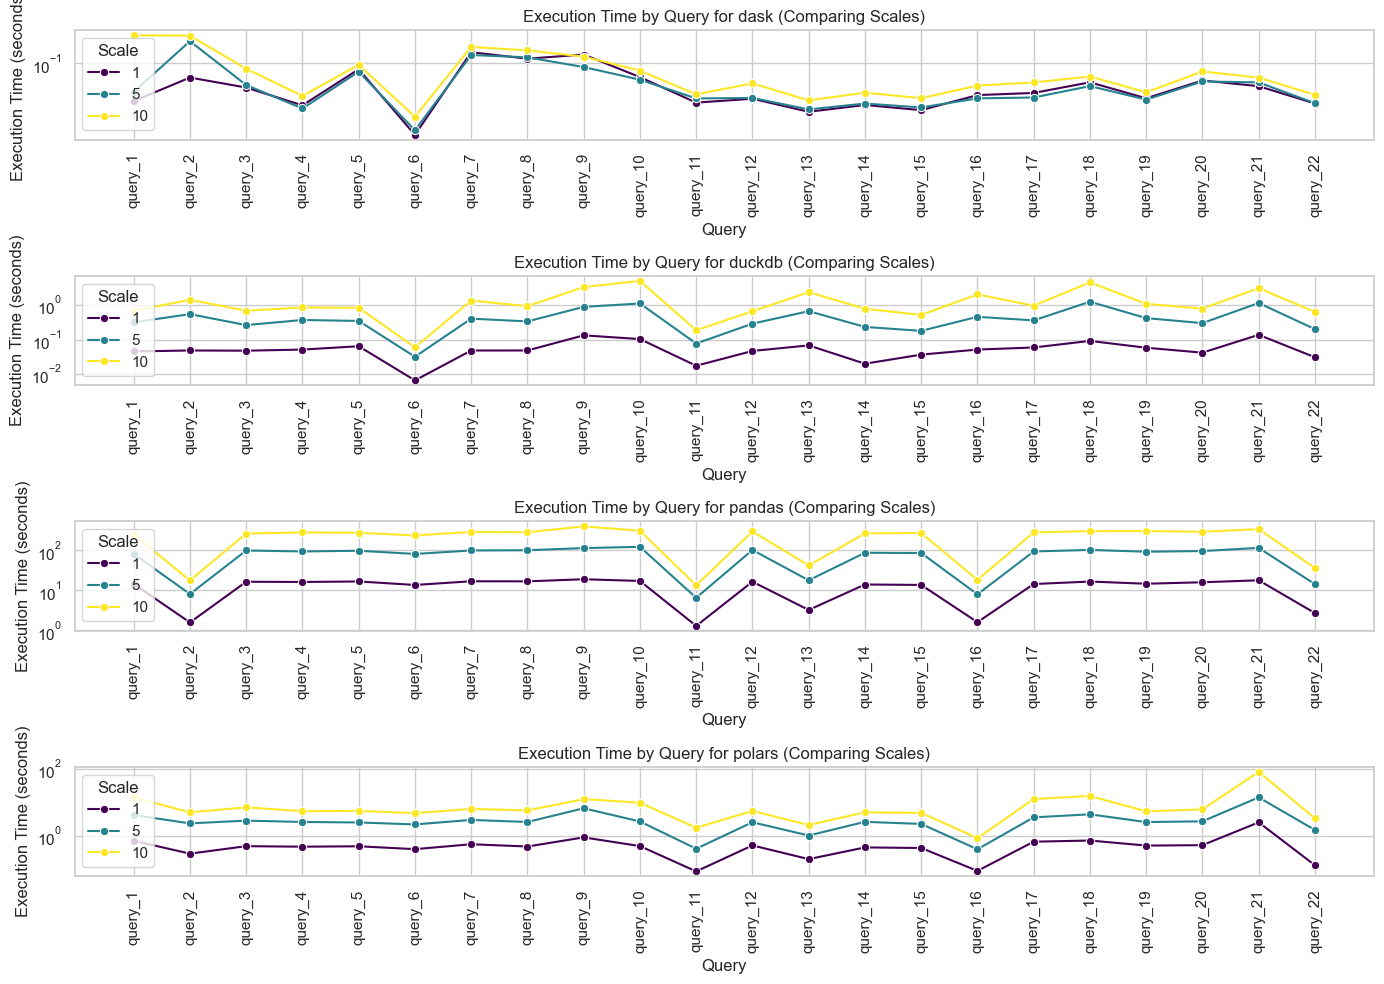

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Get unique libraries for separate plots
libraries = df["library"].unique()

# Set figure size to accommodate multiple subplots
plt.figure(figsize=(14, 10))

for i, library in enumerate(libraries, start=1):
    plt.subplot(len(libraries), 1, i)  # Create a subplot for each library in a single column
    subset = df_long[df_long["library"] == library]  # Filter data by library
    
    # Create a lineplot for the current library, showing different scales with different line styles
    sns.lineplot(data=subset, x="query", y="time", hue="scale", marker="o", palette="viridis")
    plt.yscale("log")  # Use log scale to handle wide ranges in execution times
    plt.title(f"Execution Time by Query for {library} (Comparing Scales)")
    plt.xlabel("Query")
    plt.ylabel("Execution Time (seconds)")
    plt.xticks(rotation=90)
    plt.legend(title="Scale", loc="upper left")

# Adjust layout
plt.tight_layout()
plt.show()


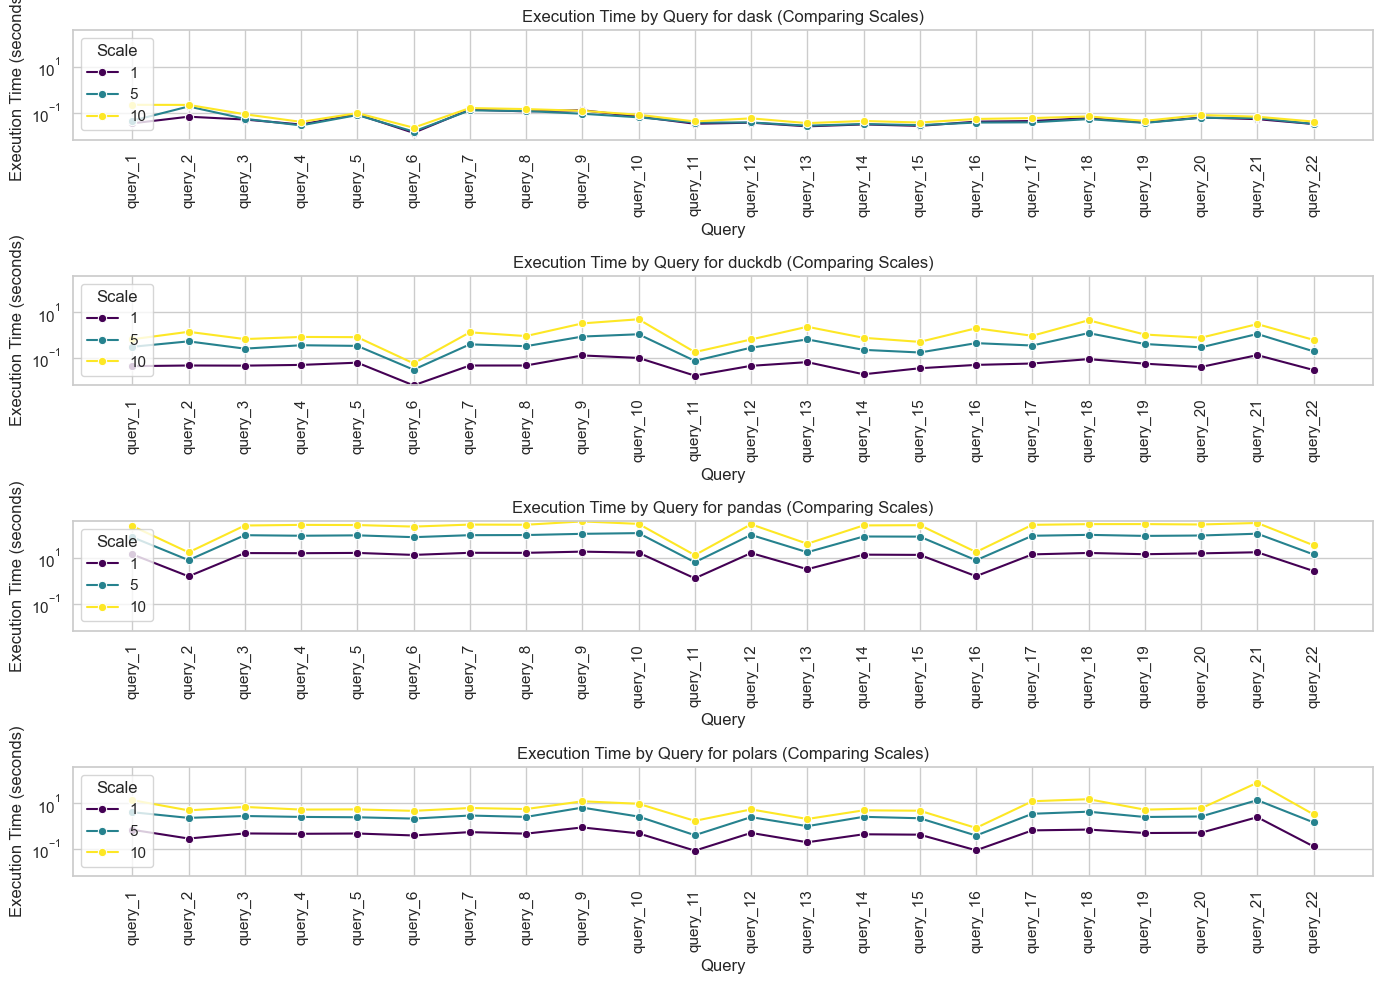

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Determine a consistent y-axis range across all data
y_min = df_long["time"].min()
y_max = df_long["time"].max()

# Get unique libraries for separate plots
libraries = df["library"].unique()

# Set figure size to accommodate multiple subplots
plt.figure(figsize=(14, 10))

for i, library in enumerate(libraries, start=1):
    plt.subplot(len(libraries), 1, i)  # Create a subplot for each library in a single column
    subset = df_long[df_long["library"] == library]  # Filter data by library
    
    # Create a lineplot for the current library, showing different scales with different line styles
    sns.lineplot(data=subset, x="query", y="time", hue="scale", marker="o", palette="viridis")
    plt.yscale("log")  # Use log scale to handle wide ranges in execution times
    plt.ylim(y_min, y_max)  # Set consistent y-axis range for all subplots
    plt.title(f"Execution Time by Query for {library} (Comparing Scales)")
    plt.xlabel("Query")
    plt.ylabel("Execution Time (seconds)")
    plt.xticks(rotation=90)
    plt.legend(title="Scale", loc="upper left")

# Adjust layout
plt.tight_layout()
plt.show()
